<a href="https://colab.research.google.com/github/RoyZhaoGA/DroughtForecastAI/blob/main/Normalized_ORG_RUN_Regression_Spatial_temporal_graph_neural_networkV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=cdcec36d7ae7ea2c3f8df113f70f0900c7659a267f8b377303820c65f01d818e
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
Gen RAM Free: 87.7 GB  |     Proc size: 99.0 MB
GPU RAM Free: 40511MB | Used: 2MB | Util   0% | Total     40960MB


In [3]:
!pip install lightning torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 31.9 MB/s eta 0:00:00


In [2]:
!pip install torch --upgrade

In [4]:
!pip uninstall torch torchvision torchaudio transformers


Found existing installation: torch 2.2.0
Uninstalling torch-2.2.0:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/torch-2.2.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
Proceed (Y/n)? Y
  Successfully uninstalled torch-2.2.0
Found existing installation: torchvision 0.16.0+cu121
Uninstalling torchvision-0.16.0+cu121:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/torchvision-0.16.0+cu121.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libcudart.7ec1eba6.so.12
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libnvjpeg.f00ca762.so.12
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libpng16.7f

In [5]:
!pip install torch torchvision torchaudio transformers

  Using cached torch-2.2.0-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 100.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.13 requires torch<2.2,>=1.10, but you have torch 2.2.0 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.2.0 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.2.0 which is incompatible.


In [4]:
# Standard libraries
import os

# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import lightning as L

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# PL callbacks
from lightning.pytorch.callbacks import ModelCheckpoint
from torch import Tensor

AVAIL_GPUS = min(1, torch.cuda.device_count())
#BATCH_SIZE = 256 if AVAIL_GPUS else 64
BATCH_SIZE = 1 if AVAIL_GPUS else 64
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/content/drive/MyDrive/DroughtCastAI/Dataset/GNNs"

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Import Graph

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pickle
# spatial-temporal edges
Graph = pickle.load(open('/content/drive/MyDrive/DroughtCastAI/Dataset/Spatial_temporal_grpah_version_2_normalized_1month_selectedX1.pickle', 'rb'))

# spatial-temporal edges
Graphy = pickle.load(open('/content/drive/MyDrive/DroughtCastAI/Dataset/Spatial_temporal_grpah_version_2_normalized_1month_selectedY1.pickle', 'rb'))

In [7]:
Graph.nodes[36986]

{'row_index': 36986,
 'Month': 202211,
 'Lat': -33.238,
 'Lon': 18.865,
 'Lat_nom': 0.0,
 'Lon_nom': 0.5263211858448558,
 'temperature_2m': 0.4952498070987658,
 'temperature_2m_min': 0.5546942683872143,
 'temperature_2m_max': 0.6508211317768104,
 'dewpoint_temperature_2m': 0.604377704250445,
 'total_precipitation_sum': 0.0144451848511847,
 'total_precipitation_min': 0.0,
 'total_precipitation_max': 0.0178303713389214,
 'u_component_of_wind_10m': 0.5135674951104923,
 'v_component_of_wind_10m': 0.4987945801799406,
 'surface_net_solar_radiation_sum': 0.7802372071127209,
 'total_evaporation_sum': 0.8615671690632722,
 'soil_moisture_am': 0.1431131537144707,
 'soil_moisture_pm': 0.1428330811346103,
 'NDVI': 0.3818963898195212,
 'EVI': 0.291882789894304,
 'next_month_tempreature': 0.4275101180905905,
 'next_month_precipitation': 0.0111730676234768,
 'year': 0.875,
 'month2': 0.9090909090909092,
 'spei01': 0.4039815,
 'next_month_soil_moisture_am': 0.210090837587329,
 'next_month_spei01': 0.68

In [8]:
len(Graph.nodes)

83580

In [9]:
len(Graph.nodes[36986])

28

**Convert Graph into pytorch geometric dataset**

1. Create torch_geometric.data

In [266]:
#EDGE INDEX FOR FULL DATASET
# Extract edge list
edge_list = list(Graph.edges())




# Convert edge list to a 2D tensor
edge_index = torch.tensor(edge_list, dtype=torch.long)
edge_index = edge_index.t().contiguous()

# Ensure the tensor shape is [2, num_edges]

edge_index = edge_index.view(2, -1)


spei01_features = [Graph.nodes[node]['next_month_spei01'] for node in Graph.nodes()]



# Convert to a tensor
y = torch.tensor(spei01_features, dtype=torch.float)

#feature_names = [ 'Lat_nom', 'Lon_nom', 'temperature_2m', 'temperature_2m_min',
#                 'temperature_2m_max', 'dewpoint_temperature_2m', 'total_precipitation_sum',
#                 'total_precipitation_min', 'total_precipitation_max', 'u_component_of_wind_10m',
#                 'v_component_of_wind_10m', 'surface_net_solar_radiation_sum', 'total_evaporation_sum',
#                 'soil_moisture_am', 'soil_moisture_pm', 'NDVI', 'EVI', 'next_month_tempreature',
#                 'next_month_precipitation', 'year', 'month2', "spei01"]

# feature_names = [  'temperature_2m',  'u_component_of_wind_10m',
#                  'v_component_of_wind_10m', 'surface_net_solar_radiation_sum', 'total_evaporation_sum',
#                  'soil_moisture_am', 'soil_moisture_pm', 'NDVI', 'EVI', 'next_month_tempreature',
#                  'next_month_precipitation',    'spei01' ]
# feature_names = [   'temperature_2m', 'temperature_2m_min',
#                 'temperature_2m_max', 'dewpoint_temperature_2m', 'total_precipitation_sum',
#                 'total_precipitation_min', 'total_precipitation_max', 'u_component_of_wind_10m',
#                 'v_component_of_wind_10m', 'surface_net_solar_radiation_sum', 'total_evaporation_sum',
#                 'soil_moisture_am', 'soil_moisture_pm', 'NDVI', 'EVI', 'next_month_tempreature',
#                 'next_month_precipitation',   "spei01"]


feature_names = [  'total_precipitation_sum',  'total_precipitation_sum',
                 'total_precipitation_sum', 'total_precipitation_sum', 'total_precipitation_sum',
                 'total_precipitation_sum', 'total_precipitation_sum', 'total_precipitation_sum', 'total_precipitation_sum', 'total_precipitation_sum',
                 'total_precipitation_sum',    'total_precipitation_sum' ]
#Extract the features for each node
node_features = []
for node in Graph.nodes():
    node_feature_values = [Graph.nodes[node].get(feature) for feature in feature_names]  # Defaulting missing values to 0
    node_features.append(node_feature_values)

# Convert to a PyTorch tensor
x = torch.tensor(node_features, dtype=torch.float)



#train_months = [201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512,
#201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608,
#201609, 201610, 201611, 201612, 201701, 201702, 201703, 201704,
#201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712,
#201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808,
#201809, 201810, 201811, 201812, 201901, 201902, 201903, 201904,
#201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912,
#202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008,
#202009, 202010, 202011, 202012, 202101, 202102]
#val_months = [202103, 202104, 202105, 202106, 202107, 202108, 202109,
#202110, 202111, 202112, 202201, 202202, 202203, 202204, 202205]
#test_months = [202206, 202207, 202208, 202209, 202210, 202211, 202212, 202301, 202302, 202303, 202304, 202305, 202306, 202307, 202308]


train_months = [201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512,
201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608,
201609, 201610, 201611, 201612, 201701, 201702, 201703, 201704,
201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712,
201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808,
201809, 201810, 201811, 201812, 201901, 201902, 201903, 201904,
201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912,
202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008,
202009, 202010, 202011, 202012, 202101, 202102, 202104, 202106,
202108,202110, 202112, 202202, 202204, 202207, 202209,202211,202301,202303, 202305,202307]
test_months = [202103, 202105,  202107, 202109,
202111, 202201, 202203, 202205]
val_months = [202206, 202208, 202210,   202212,   202302,  202304,  202306, 202307, 202308]

emb_months=[201505]
emb_mask_list = []

for node in Graph.nodes():
    is_in_emb_months = Graph.nodes[node]['Month'] in emb_months
    emb_mask_list.append(is_in_emb_months)

emb_mask = torch.tensor(emb_mask_list, dtype=torch.bool)
train_mask_list = []

for node in Graph.nodes():
    is_in_train_months = Graph.nodes[node]['Month'] in train_months
    train_mask_list.append(is_in_train_months)

train_mask = torch.tensor(train_mask_list, dtype=torch.bool)

val_mask_list = []

for node in Graph.nodes():
    is_in_val_months = Graph.nodes[node]['Month'] in val_months
    val_mask_list.append(is_in_val_months)

val_mask = torch.tensor(val_mask_list, dtype=torch.bool)

test_mask_list = []

for node in Graph.nodes():
    is_in_test_months = Graph.nodes[node]['Month'] in test_months
    test_mask_list.append(is_in_test_months)

test_mask = torch.tensor(test_mask_list, dtype=torch.bool)

graph_data = torch_geometric.data.Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask, emb_mask=emb_mask)

In [267]:
graph_data

Data(x=[83580, 12], edge_index=[2, 129700], y=[83580], train_mask=[83580], val_mask=[83580], test_mask=[83580], emb_mask=[83580])

In [268]:
graph_data.x, graph_data.y

(tensor([[0.0183, 0.0183, 0.0183,  ..., 0.0183, 0.0183, 0.0183],
         [0.0111, 0.0111, 0.0111,  ..., 0.0111, 0.0111, 0.0111],
         [0.0090, 0.0090, 0.0090,  ..., 0.0090, 0.0090, 0.0090],
         ...,
         [0.0074, 0.0074, 0.0074,  ..., 0.0074, 0.0074, 0.0074],
         [0.0043, 0.0043, 0.0043,  ..., 0.0043, 0.0043, 0.0043],
         [0.0037, 0.0037, 0.0037,  ..., 0.0037, 0.0037, 0.0037]]),
 tensor([0.5642, 0.7461, 0.6896,  ..., 0.3055, 0.2828, 0.2375]))

In [269]:
print(train_mask)

tensor([ True,  True,  True,  ..., False, False, False])


2. Create dataset

In [240]:
from torch.utils.data import Dataset, DataLoader

In [270]:
class GraphDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.num_node_features = data.x.size(1)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.data

In [271]:
graph_dataset = GraphDataset(graph_data)

In [272]:
graph_dataset.data

Data(x=[83580, 12], edge_index=[2, 129700], y=[83580], train_mask=[83580], val_mask=[83580], test_mask=[83580], emb_mask=[83580])

In [273]:
graph_dataset.__getitem__(0)

Data(x=[83580, 12], edge_index=[2, 129700], y=[83580], train_mask=[83580], val_mask=[83580], test_mask=[83580], emb_mask=[83580])

In [274]:
graph_dataset.num_node_features

12

## Graph Neural Network

**1. Setup GNN Module**

In [22]:
gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv, "GraphConv": geom_nn.GraphConv, "SAGEConv": geom_nn.SAGEConv, "GAT2": geom_nn.GATv2Conv}

In [81]:
class GNNModel(nn.Module):
    def __init__(
        self,
        c_in,
        c_out,
        num_layers=1,
        layer_name="GCN",
        dp_rate=0.1,
        **kwargs,
    ):
        """GNNModel.

        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of "hidden" graph layers
            layer_name: String of the graph layer to use
            dp_rate: Dropout rate to apply throughout the network
            kwargs: Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        layers = []
   #     Layer 1  GAT
        gnn_layer1= geom_nn.GATv2Conv
        layers += [
            gnn_layer1(12, 7),
            nn.Tanh(),
           nn.Dropout(dp_rate)
        ]
       # Layer 2  GraphSAGE
        gnn_layer2= geom_nn.SAGEConv
        layers += [
            gnn_layer2(7, 7),
            nn.Tanh(),

            nn.Dropout(dp_rate)
        ]

        #Layer 3 Post-Message Passing
        mp_layer = nn.Sequential(
            nn.Linear(7, 7),
            nn.Tanh(),
            nn.Dropout(dp_rate),
            nn.Linear(7, 1)


           # nn.Sigmoid()


        )
        self.post_mp = mp_layer

        print("GNN layers:")
        print(layers)
        self.layers = nn.ModuleList(layers)
        print("Post layers:")
        print(mp_layer)

    def forward(self, x, edge_index):
        """Forward.

        Args:
            x: Input features per node,data.x
            edge_index: data.edge_indexList of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        i=0
        # process EMB GNN Layer
        for layer in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
          # print("layer", i);
            i+=1
          #  print(layer)
            if isinstance(layer, geom_nn.MessagePassing):

                x = layer(x, edge_index)
                emb=x
            else:
                x = layer(x)
        # process Post MP Layer
        x = self.post_mp(x)
       # print("----x:")
       # print(x)
       # print(x.size())
        return x, emb

In [24]:
global GModel

**2. Define Lightning Module - NodeLevelRegressionGNN**

LightningModule organizes your PyTorch code into 6 sections:

1. Initialization (__init__ and setup()).

2. Train Loop (training_step())

3. Validation Loop (validation_step())

4. Test Loop (test_step())

5. Prediction Loop (predict_step())

6. Optimizers and LR Schedulers (configure_optimizers())

In [117]:
loss_list = []

class NodeLevelRegressionGNN(L.LightningModule):
    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        # Initialize the model
        self.model = GNNModel(**model_kwargs)  # Ensure GNNModel outputs continuous values

        # Use Mean Squared Error Loss for regression
        self.loss_module = nn.MSELoss()
       # self.loss_module = nn.L1Loss()

    def forward(self, data, mode="train"):

        x, edge_index = data.x, data.edge_index
        #call model forward function
        x, emb = self.model(x, edge_index)

        global x_tensor, x_tensor_test, x_tensor_val
        global y_tensor, y_tensor_test, y_tensor_val
        global x_tensor_emb, x_tensor_test_emb, x_tensor_val_emb
        global y_tensor_emb, y_tensor_test_emb, y_tensor_val_emb
        # x_tensor = x
        # y_tensor = data.y
        mask2 = data.emb_mask
        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
            x_tensor = x[mask]
            y_tensor = data.y[mask]
            x_tensor_emb = emb[mask]
            y_tensor_emb = data.y[mask]
        elif mode == "val":
            mask = data.val_mask
            x_tensor_val = x[mask]
            y_tensor_val = data.y[mask]
            # x_tensor_val_emb = emb[mask]
            # y_tensor_val_emb = data.y[mask]
        elif mode == "test":
            mask = data.test_mask
            x_tensor_test = x[mask]
            y_tensor_test = data.y[mask]
            # x_tensor_test_emb = emb[mask]
            # y_tensor_test_emb = data.y[mask]

        else:
            raise ValueError(f"Unknown forward mode: {mode}")
        # print("mode is", mode)
        # print("mask is", mask )
        # print("x is ", x)
        # print("xMask is ", x[mask] )

        xMask=x[mask].squeeze()
        #yMask=data.y[mask].squeeze
        loss = self.loss_module(xMask, data.y[mask])

        print("Loss: ")
        print(loss)
        return loss

    def configure_optimizers(self):
        # Optimizer can be adjusted as needed
        #optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3)
       # optimizer = optim.Adam(self.parameters(),lr=0.001,)
        optimizer = optim.Adam(self.parameters(),lr=0.01, weight_decay=5e-4)

        return optimizer

    def training_step(self, batch, batch_idx):
        loss = self.forward(batch, mode="train")
        loss_list.append(loss.item())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.forward(batch, mode="val")
        self.log("val_loss", loss)
        print("#####################val_loss",loss)

    def test_step(self, batch, batch_idx):
        loss = self.forward(batch, mode="test")
        self.log("test_loss", loss)

**3. Define Node-level regression Master Trainer  - Train_Node Regression**

In [175]:
def train_node_regressor(model_name, dataset, **model_kwargs):
    L.seed_everything(42)
    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)

    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevelRegression" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = L.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss")],
        accelerator="auto",
        devices=AVAIL_GPUS,
        max_epochs=300,
        gradient_clip_val=30,
        enable_progress_bar=True
    )

    pretrained_filename = "bruh"
    os.path.join(CHECKPOINT_PATH, "NodeLevelRegression%s.ckpt" % model_name)
   # if os.path.isfile(pretrained_filename):
   #     print("Found pretrained model, loading...")
   #     model = NodeLevelRegressionGNN.load_from_checkpoint(pretrained_filename)
   # else:
    L.seed_everything()
    # Ensure the model's output layer and loss are suitable for regression
    model = NodeLevelRegressionGNN(
         model_name=model_name, c_in=dataset.num_node_features, c_out=1, **model_kwargs
    )
    #Start Training
    trainer.fit(model, node_data_loader, node_data_loader)
    print("checkpoint_callback model path",trainer.checkpoint_callback.best_model_path)
    model = NodeLevelRegressionGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test the best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader, verbose=True)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    train_loss = model.forward(batch, mode="train")
    val_loss = model.forward(batch, mode="val")
    result = {"train_loss": train_loss, "val_loss": val_loss, "test_loss": test_result[0]["test_loss"]}
    return model, result

In [98]:
# Small function for printing the test scores
def print_results(result_dict):
    if "train_loss" in result_dict:
        print("Train loss: " + str(result_dict["train_loss"]))
    if "val_loss" in result_dict:
        print("Val loss: " + str(result_dict["val_loss"]))
    print("Test loss: " + str(result_dict["test_loss"]))

**Run Model**

In [275]:

loss_list = []

node_gnn_model, node_gnn_result = train_node_regressor( model_name="GNN",dataset=graph_dataset)

print_results(node_gnn_result)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type     | Params
------

GNN layers:
[GATv2Conv(12, 7, heads=1), Tanh(), Dropout(p=0.1, inplace=False), SAGEConv(7, 7, aggr=mean), Tanh(), Dropout(p=0.1, inplace=False)]
Post layers:
Sequential(
  (0): Linear(in_features=7, out_features=7, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=7, out_features=1, bias=True)
)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Loss: 
tensor(0.6089, device='cuda:0')
#####################val_loss tensor(0.6089, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.5912, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.4918, device='cuda:0')
#####################val_loss tensor(0.4918, device='cuda:0')
Loss: 
tensor(0.4740, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.3885, device='cuda:0')
#####################val_loss tensor(0.3885, device='cuda:0')
Loss: 
tensor(0.3709, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.2953, device='cuda:0')
#####################val_loss tensor(0.2953, device='cuda:0')
Loss: 
tensor(0.2806, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.2118, device='cuda:0')
#####################val_loss tensor(0.2118, device='cuda:0')
Loss: 
tensor(0.2003, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.1398, device='cuda:0')
#####################val_loss tensor(0.1398, device='cuda:0')
Loss: 
tensor(0.1327, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0827, device='cuda:0')
#####################val_loss tensor(0.0827, device='cuda:0')
Loss: 
tensor(0.0820, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0443, device='cuda:0')
#####################val_loss tensor(0.0443, device='cuda:0')
Loss: 
tensor(0.0501, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0270, device='cuda:0')
#####################val_loss tensor(0.0270, device='cuda:0')
Loss: 
tensor(0.0407, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0291, device='cuda:0')
#####################val_loss tensor(0.0291, device='cuda:0')
Loss: 
tensor(0.0506, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0425, device='cuda:0')
#####################val_loss tensor(0.0425, device='cuda:0')
Loss: 
tensor(0.0701, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0560, device='cuda:0')
#####################val_loss tensor(0.0560, device='cuda:0')
Loss: 
tensor(0.0870, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0626, device='cuda:0')
#####################val_loss tensor(0.0626, device='cuda:0')
Loss: 
tensor(0.0944, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0608, device='cuda:0')
#####################val_loss tensor(0.0608, device='cuda:0')
Loss: 
tensor(0.0921, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0527, device='cuda:0')
#####################val_loss tensor(0.0527, device='cuda:0')
Loss: 
tensor(0.0812, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0420, device='cuda:0')
#####################val_loss tensor(0.0420, device='cuda:0')
Loss: 
tensor(0.0673, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0320, device='cuda:0')
#####################val_loss tensor(0.0320, device='cuda:0')
Loss: 
tensor(0.0542, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0251, device='cuda:0')
#####################val_loss tensor(0.0251, device='cuda:0')
Loss: 
tensor(0.0444, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0226, device='cuda:0')
#####################val_loss tensor(0.0226, device='cuda:0')
Loss: 
tensor(0.0394, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0242, device='cuda:0')
#####################val_loss tensor(0.0242, device='cuda:0')
Loss: 
tensor(0.0386, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0284, device='cuda:0')
#####################val_loss tensor(0.0284, device='cuda:0')
Loss: 
tensor(0.0427, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0336, device='cuda:0')
#####################val_loss tensor(0.0336, device='cuda:0')
Loss: 
tensor(0.0464, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0379, device='cuda:0')
#####################val_loss tensor(0.0379, device='cuda:0')
Loss: 
tensor(0.0502, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0403, device='cuda:0')
#####################val_loss tensor(0.0403, device='cuda:0')
Loss: 
tensor(0.0521, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0404, device='cuda:0')
#####################val_loss tensor(0.0404, device='cuda:0')
Loss: 
tensor(0.0514, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0385, device='cuda:0')
#####################val_loss tensor(0.0385, device='cuda:0')
Loss: 
tensor(0.0496, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0353, device='cuda:0')
#####################val_loss tensor(0.0353, device='cuda:0')
Loss: 
tensor(0.0461, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0315, device='cuda:0')
#####################val_loss tensor(0.0315, device='cuda:0')
Loss: 
tensor(0.0426, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0280, device='cuda:0')
#####################val_loss tensor(0.0280, device='cuda:0')
Loss: 
tensor(0.0392, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0252, device='cuda:0')
#####################val_loss tensor(0.0252, device='cuda:0')
Loss: 
tensor(0.0366, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0235, device='cuda:0')
#####################val_loss tensor(0.0235, device='cuda:0')
Loss: 
tensor(0.0355, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0226, device='cuda:0')
#####################val_loss tensor(0.0226, device='cuda:0')
Loss: 
tensor(0.0355, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0226, device='cuda:0')
#####################val_loss tensor(0.0226, device='cuda:0')
Loss: 
tensor(0.0357, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0362, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0233, device='cuda:0')
#####################val_loss tensor(0.0233, device='cuda:0')
Loss: 
tensor(0.0372, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0236, device='cuda:0')
#####################val_loss tensor(0.0236, device='cuda:0')
Loss: 
tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0236, device='cuda:0')
#####################val_loss tensor(0.0236, device='cuda:0')
Loss: 
tensor(0.0366, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0234, device='cuda:0')
#####################val_loss tensor(0.0234, device='cuda:0')
Loss: 
tensor(0.0363, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0230, device='cuda:0')
#####################val_loss tensor(0.0230, device='cuda:0')
Loss: 
tensor(0.0352, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0226, device='cuda:0')
#####################val_loss tensor(0.0226, device='cuda:0')
Loss: 
tensor(0.0334, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0328, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0233, device='cuda:0')
#####################val_loss tensor(0.0233, device='cuda:0')
Loss: 
tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0239, device='cuda:0')
#####################val_loss tensor(0.0239, device='cuda:0')
Loss: 
tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0247, device='cuda:0')
#####################val_loss tensor(0.0247, device='cuda:0')
Loss: 
tensor(0.0323, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0254, device='cuda:0')
#####################val_loss tensor(0.0254, device='cuda:0')
Loss: 
tensor(0.0325, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0259, device='cuda:0')
#####################val_loss tensor(0.0259, device='cuda:0')
Loss: 
tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0262, device='cuda:0')
#####################val_loss tensor(0.0262, device='cuda:0')
Loss: 
tensor(0.0328, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0262, device='cuda:0')
#####################val_loss tensor(0.0262, device='cuda:0')
Loss: 
tensor(0.0327, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0259, device='cuda:0')
#####################val_loss tensor(0.0259, device='cuda:0')
Loss: 
tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0254, device='cuda:0')
#####################val_loss tensor(0.0254, device='cuda:0')
Loss: 
tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0249, device='cuda:0')
#####################val_loss tensor(0.0249, device='cuda:0')
Loss: 
tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0243, device='cuda:0')
#####################val_loss tensor(0.0243, device='cuda:0')
Loss: 
tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0237, device='cuda:0')
#####################val_loss tensor(0.0237, device='cuda:0')
Loss: 
tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0233, device='cuda:0')
#####################val_loss tensor(0.0233, device='cuda:0')
Loss: 
tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0230, device='cuda:0')
#####################val_loss tensor(0.0230, device='cuda:0')
Loss: 
tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0226, device='cuda:0')
#####################val_loss tensor(0.0226, device='cuda:0')
Loss: 
tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0226, device='cuda:0')
#####################val_loss tensor(0.0226, device='cuda:0')
Loss: 
tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0226, device='cuda:0')
#####################val_loss tensor(0.0226, device='cuda:0')
Loss: 
tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0226, device='cuda:0')
#####################val_loss tensor(0.0226, device='cuda:0')
Loss: 
tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0231, device='cuda:0')
#####################val_loss tensor(0.0231, device='cuda:0')
Loss: 
tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0232, device='cuda:0')
#####################val_loss tensor(0.0232, device='cuda:0')
Loss: 
tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0234, device='cuda:0')
#####################val_loss tensor(0.0234, device='cuda:0')
Loss: 
tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0235, device='cuda:0')
#####################val_loss tensor(0.0235, device='cuda:0')
Loss: 
tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0236, device='cuda:0')
#####################val_loss tensor(0.0236, device='cuda:0')
Loss: 
tensor(0.0292, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0237, device='cuda:0')
#####################val_loss tensor(0.0237, device='cuda:0')
Loss: 
tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0236, device='cuda:0')
#####################val_loss tensor(0.0236, device='cuda:0')
Loss: 
tensor(0.0292, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0235, device='cuda:0')
#####################val_loss tensor(0.0235, device='cuda:0')
Loss: 
tensor(0.0291, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0234, device='cuda:0')
#####################val_loss tensor(0.0234, device='cuda:0')
Loss: 
tensor(0.0290, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0233, device='cuda:0')
#####################val_loss tensor(0.0233, device='cuda:0')
Loss: 
tensor(0.0284, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0231, device='cuda:0')
#####################val_loss tensor(0.0231, device='cuda:0')
Loss: 
tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0230, device='cuda:0')
#####################val_loss tensor(0.0230, device='cuda:0')
Loss: 
tensor(0.0284, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0288, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0284, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0280, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0230, device='cuda:0')
#####################val_loss tensor(0.0230, device='cuda:0')
Loss: 
tensor(0.0280, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0230, device='cuda:0')
#####################val_loss tensor(0.0230, device='cuda:0')
Loss: 
tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0231, device='cuda:0')
#####################val_loss tensor(0.0231, device='cuda:0')
Loss: 
tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0231, device='cuda:0')
#####################val_loss tensor(0.0231, device='cuda:0')
Loss: 
tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0231, device='cuda:0')
#####################val_loss tensor(0.0231, device='cuda:0')
Loss: 
tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0231, device='cuda:0')
#####################val_loss tensor(0.0231, device='cuda:0')
Loss: 
tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0231, device='cuda:0')
#####################val_loss tensor(0.0231, device='cuda:0')
Loss: 
tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0230, device='cuda:0')
#####################val_loss tensor(0.0230, device='cuda:0')
Loss: 
tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0230, device='cuda:0')
#####################val_loss tensor(0.0230, device='cuda:0')
Loss: 
tensor(0.0272, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0272, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0273, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0267, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0230, device='cuda:0')
#####################val_loss tensor(0.0230, device='cuda:0')
Loss: 
tensor(0.0267, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0230, device='cuda:0')
#####################val_loss tensor(0.0230, device='cuda:0')
Loss: 
tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0230, device='cuda:0')
#####################val_loss tensor(0.0230, device='cuda:0')
Loss: 
tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0230, device='cuda:0')
#####################val_loss tensor(0.0230, device='cuda:0')
Loss: 
tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0230, device='cuda:0')
#####################val_loss tensor(0.0230, device='cuda:0')
Loss: 
tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0264, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0262, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0255, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0254, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0254, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0254, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
Loss: 
tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=300` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


Loss: 
tensor(0.0227, device='cuda:0')
#####################val_loss tensor(0.0227, device='cuda:0')
checkpoint_callback model path /content/drive/MyDrive/DroughtCastAI/Dataset/GNNs/NodeLevelRegressionGNN/lightning_logs/version_470/checkpoints/epoch=31-step=32.ckpt


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GNN layers:
[GATv2Conv(12, 7, heads=1), Tanh(), Dropout(p=0.1, inplace=False), SAGEConv(7, 7, aggr=mean), Tanh(), Dropout(p=0.1, inplace=False)]
Post layers:
Sequential(
  (0): Linear(in_features=7, out_features=7, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=7, out_features=1, bias=True)
)


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0170, device='cuda:0')


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.016987202689051628    │
└───────────────────────────┴───────────────────────────┘

Loss: 
tensor(0.0357, grad_fn=<MseLossBackward0>)
Loss: 
tensor(0.0407, grad_fn=<MseLossBackward0>)
Train loss: tensor(0.0357, grad_fn=<MseLossBackward0>)
Val loss: tensor(0.0407, grad_fn=<MseLossBackward0>)
Test loss: 0.016987202689051628


In [276]:
#Predicted values
x_tensor

tensor([[0.4929],
        [0.5482],
        [0.2464],
        ...,
        [0.1398],
        [0.5421],
        [0.1779]], grad_fn=<IndexBackward0>)

In [607]:
torch.mean(x_tensor)

tensor(0.4210, grad_fn=<MeanBackward0>)

In [263]:
torch.std(x_tensor)

tensor(0.1388, grad_fn=<StdBackward0>)

In [651]:
torch.min(x_tensor)

tensor(-0.1445, grad_fn=<MinBackward1>)

In [547]:
torch.max(x_tensor)

tensor(0.6631, grad_fn=<MaxBackward1>)

In [ ]:
x_tensor.size()

torch.Size([83580, 1])

In [631]:
#Actual values
y_tensor

tensor([0.5642, 0.7461, 0.6896,  ..., 0.2343, 0.3504, 0.3945])

In [220]:
torch.std(y_tensor)

tensor(0.1337)

In [519]:
y_tensor.std()

tensor(0.1345, device='cuda:0')

In [ ]:
y_tensor.mean()

tensor(0.4353)

**Result - MAE**

In [221]:
from sklearn.metrics import mean_absolute_error
import torch


def calculateMAE(actual, predicted):
  # Assuming 'actual' and 'predicted' are PyTorch tensors
  # actual = torch.tensor([...])  # Replace with your actual values tensor
  # predicted = torch.tensor([...])  # Replace with your predicted values tensor

  # Convert tensors to numpy arrays
 # predicted = x_tensor_test.clone()
 # actual=y_tensor_test


  #
  actual_np = actual.cpu().detach().numpy()
  predicted_np = predicted.cpu().detach().numpy()

  # Calculate MAE using scikit-learn
  mae = mean_absolute_error(actual_np, predicted_np)
  print("Mean Absolute Error (MAE):", mae)


In [160]:
calculateMAE(x_tensor_test.clone().squeeze(),y_tensor_test)

Mean Absolute Error (MAE): 0.076294005


In [222]:
# Example 1D tensors
print(x_tensor_test);

print(y_tensor_test);

x_tensor_d=x_tensor_test.clone().squeeze()
y_tensor_d=y_tensor_test.clone().squeeze()




# Ensure the tensors are 1D and have the same length
assert x_tensor_d.ndim == 1 and y_tensor_d.ndim == 1
assert len(x_tensor) == len(y_tensor)

# Create the mask and apply it
mask = x_tensor_d > 0.45

x_tensor3 = x_tensor_d[mask]
y_tensor3 = y_tensor_d[mask]

mask2 = x_tensor_d < 0.45
x_tensor3b = x_tensor_d[mask2]
y_tensor3b = y_tensor_d[mask2]


print(len(x_tensor_d));
print(len(x_tensor3));

print(len(x_tensor3b));


tensor([[0.3165],
        [0.2861],
        [0.2765],
        ...,
        [0.2101],
        [0.2126],
        [0.1189]], device='cuda:0')
tensor([0.3392, 0.3370, 0.3255,  ..., 0.2472, 0.2494, 0.1650], device='cuda:0')
6688
2733
3955


In [223]:
calculateMAE(x_tensor3,y_tensor3)
calculateMAE(x_tensor3b,y_tensor3b)


Mean Absolute Error (MAE): 0.043742314
Mean Absolute Error (MAE): 0.03879511


In [224]:
from sklearn.metrics import r2_score
import torch

# Assuming 'actual' and 'predicted' are PyTorch tensors
# actual = torch.tensor([1, 2, 3, 4, 5])  # Replace with your actual values tensor
# predicted = torch.tensor([1.1, 2.2, 2.9, 4.1, 5.1])  # Replace with your predicted values tensor
predicted=x_tensor
actual=y_tensor
# Convert tensors to numpy arrays
actual_np = actual.cpu().detach().numpy()
predicted_np = predicted.cpu().detach().numpy()

# Calculate R-Squared
r_squared = abs(r2_score(actual_np, predicted_np))
print("R-Squared:", r_squared)


R-Squared: 0.5990854094439526


**Redult-RSME**

In [225]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch

# Assuming 'actual' and 'predicted' are PyTorch tensors
# actual = torch.tensor([...])  # Replace with your actual values tensor
# predicted = torch.tensor([...])  # Replace with your predicted values tensor
predicted=x_tensor_test
actual=y_tensor_test
# Convert tensors to numpy arrays
actual_np = actual.cpu().detach().numpy()
predicted_np = predicted.cpu().detach().numpy()

# Calculate RMSE
mse = mean_squared_error(actual_np, predicted_np)
rmse = sqrt(mse)
print("RMSE:", rmse)

predicted=x_tensor3
actual=y_tensor3
# Convert tensors to numpy arrays
actual_np = actual.cpu().detach().numpy()
predicted_np = predicted.cpu().detach().numpy()

# Calculate RMSE
mse = mean_squared_error(actual_np, predicted_np)
rmse = sqrt(mse)
print("RMSE:", rmse)

predicted=x_tensor3b
actual=y_tensor3b
# Convert tensors to numpy arrays
actual_np = actual.cpu().detach().numpy()
predicted_np = predicted.cpu().detach().numpy()

# Calculate RMSE
mse = mean_squared_error(actual_np, predicted_np)
rmse = sqrt(mse)
print("RMSE:", rmse)


RMSE: 0.054526519983555274
RMSE: 0.05699819299171771
RMSE: 0.052750916006114694


**Result-EPOCH LOSS Diagram**

In [226]:
import matplotlib.pyplot as plt
import torch

def plot_loss_graph(loss_data):
    """
    Plots the training loss over epochs.

    :param loss_data: List of loss values (as PyTorch tensors).
    """
    # Convert tensor list to a list of Python floats

    # Epochs (assuming each loss value corresponds to an epoch)
    epochs = range(1, len(loss_data) + 1)

    # Creating the plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss_data, marker='o', color='b', label='Training Loss')

    # Adding titles and labels
    plt.title('Epochs vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plot
    plt.show()


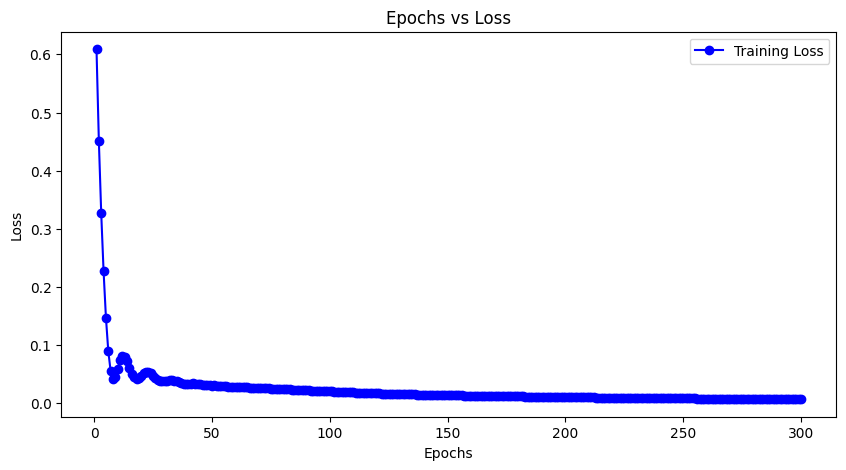

In [187]:
plot_loss_graph(loss_list)

In [227]:
# Example 1D tensors
print(x_tensor);

print(y_tensor);

x_tensor_d=x_tensor.squeeze()
y_tensor_d=y_tensor.squeeze()




# Ensure the tensors are 1D and have the same length
assert x_tensor_d.ndim == 1 and y_tensor_d.ndim == 1
assert len(x_tensor) == len(y_tensor)

# Create the mask and apply it
mask = x_tensor_d > 0.5
x_tensor3 = x_tensor_d[mask]
y_tensor3 = y_tensor_d[mask]


print(len(x_tensor_d));
print(len(x_tensor3));


tensor([[0.6183],
        [0.8879],
        [0.5024],
        ...,
        [0.2666],
        [0.3512],
        [0.3359]], grad_fn=<IndexBackward0>)
tensor([0.5642, 0.7461, 0.6896,  ..., 0.2343, 0.3504, 0.3945])
70204
18909


**RESULT - Prediction vs Actual**

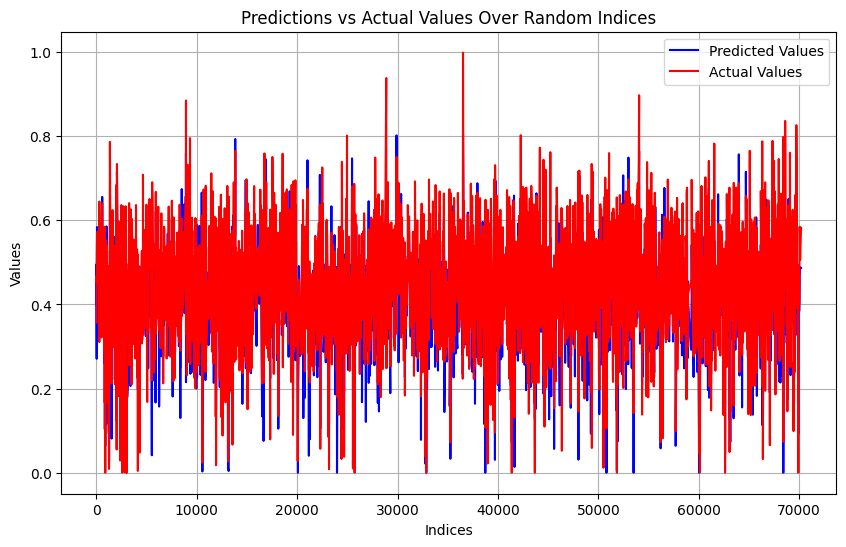

In [231]:
import numpy as np
import matplotlib.pyplot as plt



random_indices = np.random.choice(len(x_tensor),3000, replace=False)
random_indices_sorted = np.sort(random_indices)

# Select elements from tensor_x and tensor_y based on these indices
selected_tensor_x = x_tensor2[random_indices].detach()
selected_tensor_y = y_tensor[random_indices].detach()

plt.figure(figsize=(10, 6))

# Plotting the lines
plt.plot(random_indices_sorted, selected_tensor_x.numpy(), label='Predicted Values', color='blue')
plt.plot(random_indices_sorted, selected_tensor_y.numpy(), label='Actual Values', color='red')

plt.title("Predictions vs Actual Values Over Random Indices")
plt.xlabel("Indices")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

In [229]:
print(x_tensor);
print(x_tensor.max)
print(y_tensor);
x_tensor2=x_tensor
x_tensor2[x_tensor2 > 0.5] *= 0.9
x_tensor2[x_tensor2 < 0] = 0

tensor([[0.6183],
        [0.8879],
        [0.5024],
        ...,
        [0.2666],
        [0.3512],
        [0.3359]], grad_fn=<IndexBackward0>)
<built-in method max of Tensor object at 0x7caee1897f10>
tensor([0.5642, 0.7461, 0.6896,  ..., 0.2343, 0.3504, 0.3945])


RESULT = TSNE Embeding

In [277]:

print(x_tensor_emb)
print(x_tensor_emb.shape )
print(y_tensor_emb)
print(y_tensor_emb.shape )
y_mask=y_tensor_emb<1
y_tensor_emb2=y_tensor_emb[y_mask]
x_tensor_emb2=x_tensor_emb[y_mask]
rounded_y_tensor_emb2 = torch.round(y_tensor_emb2  * 10) / 10

print(x_tensor_emb2 )
print(y_tensor_emb2  )

print(rounded_y_tensor_emb2 )

tensor([[-0.7094, -0.2808, -0.3492,  ..., -0.1610, -0.0020, -0.4094],
        [-0.7850, -0.2889, -0.3854,  ..., -0.2622,  0.0023, -0.3749],
        [-0.7822, -0.2868, -0.3824,  ..., -0.2610,  0.0014, -0.3756],
        ...,
        [-0.6510, -0.4910, -0.3892,  ..., -0.2220, -0.5015, -0.5915],
        [-0.7733, -0.2799, -0.3729,  ..., -0.2572, -0.0016, -0.3778],
        [-0.7725, -0.2793, -0.3720,  ..., -0.2568, -0.0018, -0.3780]],
       grad_fn=<IndexBackward0>)
torch.Size([70204, 7])
tensor([0.5642, 0.7461, 0.6896,  ..., 0.2343, 0.3504, 0.3945])
torch.Size([70204])
tensor([[-0.7094, -0.2808, -0.3492,  ..., -0.1610, -0.0020, -0.4094],
        [-0.7850, -0.2889, -0.3854,  ..., -0.2622,  0.0023, -0.3749],
        [-0.7822, -0.2868, -0.3824,  ..., -0.2610,  0.0014, -0.3756],
        ...,
        [-0.6510, -0.4910, -0.3892,  ..., -0.2220, -0.5015, -0.5915],
        [-0.7733, -0.2799, -0.3729,  ..., -0.2572, -0.0016, -0.3778],
        [-0.7725, -0.2793, -0.3720,  ..., -0.2568, -0.0018, -0.3

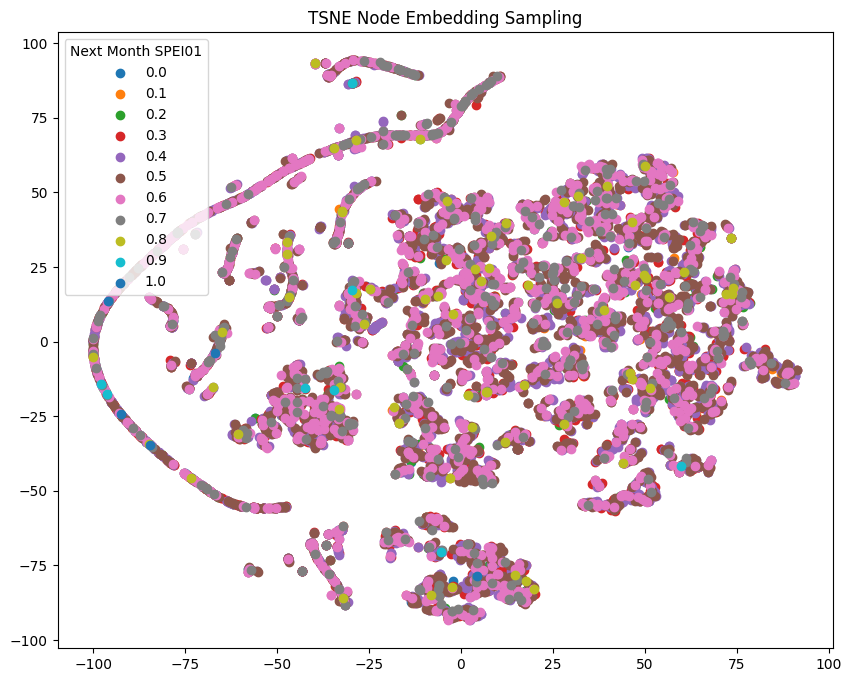

In [279]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

# Assuming x_tensor is your original large tensor
x_tensor =x_tensor_emb2  # Replace with your large tensor

# Assuming labels is a tensor or array of labels corresponding to each data point in x_tensor
labels = rounded_y_tensor_emb2
# Define the sample size
sample_size = 10000  # Adjust this to your desired sample size

# Ensure the sample size is not larger than the number of data points
if sample_size > x_tensor.size(0):
    sample_size = x_tensor.size(0)

# Randomly sample indices
indices = torch.randperm(x_tensor.size(0))[:sample_size]

# Select the samples and corresponding labels
sampled_x_tensor = x_tensor[indices]
sampled_labels = labels[indices]

# Detach and move to CPU, then convert to NumPy array
X_np = sampled_x_tensor.detach().cpu().numpy()

# Create a t-SNE instance: you can adjust parameters
tsne = TSNE(n_components=2, random_state=42)

# Apply t-SNE to the sampled data
X_2d = tsne.fit_transform(X_np)

# Plot the transformed sampled data with labels
plt.figure(figsize=(10, 8))
for label in torch.unique(sampled_labels):
    idx = (sampled_labels == label)
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1],  label=f'{label:.1f}')

plt.title("TSNE Node Embedding Sampling")

plt.legend(title="Next Month SPEI01")
plt.show()
